In [12]:
import os
import pandas as pd
import numpy as np
import jieba
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec


def cos():
    """
    jieba分词后计算余弦相似度
    :return:
    """
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['desc_cut'])
    similarity_matrix = cosine_similarity(X)
    indices = np.where(similarity_matrix > 0.6)
    print(indices[0], indices[1])

    #
    for r, c in zip(indices[0], indices[1]):
        if similarity_matrix[r][c] > 0.5:
            if df['target_desc'].values[r] != df['target_desc'].values[c]:
                print(similarity_matrix[r][c], df['target_desc'].values[r], df['target_desc'].values[c])


def w2v(df):
    # 将分词后的文本转换为列表形式
    sentences = [desc.split() for desc in df['seg_desc']]

    # 训练Word2Vec模型
    model = Word2Vec(sentences, vector_size=80, window=2, min_count=1, workers=4)

    # 获取每个元素的Word2Vec向量表示
    vec_desc = df['seg_desc'].apply(lambda x: [model.wv[word] for word in x.split()])

    # 输出每个元素的Word2Vec向量表示
    return vec_desc


def get_cos_similarities(df):
    # 计算每个元素之间的相似性
    similarities = []
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            sim = cosine_similarity(df['vec_desc'].iloc[i], df['vec_desc'].iloc[j])
            similarities.append((i, j, sim))

    # 输出相似性结果
    sim_list = []
    for i, j, sim in similarities:
        # print(f"Element {i} and Element {j} similarity: {sim}")
        # print(f"{df['seg_desc'].values[i]} and {df['seg_desc'].values[j]} similarity: {sim}")
        if df['target_desc'].values[i] != df['target_desc'].values[j]:
            sim_list.append([df['target_desc'].values[i], df['target_desc'].values[j], np.mean(sim)])
    sim_df = pd.DataFrame(sim_list, columns=['name_1', 'name_2', 'sim'])
    print(sim_df)
    sim_df.boxplot(column='sim')
    return sim_df

         name_1    name_2       sim
0        泵驱动占空比      闭环系数 -0.003034
1        泵驱动占空比  部分再生成功次数 -0.058597
2        泵驱动占空比  部分再生成功次数 -0.058597
3        泵驱动占空比      参考扭矩  0.031346
4        泵驱动占空比        车速  0.052055
...         ...       ...       ...
55179  Trip尿素消耗    Trip油耗  0.128251
55180  Trip尿素消耗     总尿素消耗  0.194713
55181  Trip尿素消耗    Trip油耗  0.128251
55182  Trip尿素消耗     总尿素消耗  0.194713
55183    Trip油耗     总尿素消耗 -0.030651

[55184 rows x 3 columns]


,name_1,name_2,sim
0,泵驱动占空比,闭环系数,-0.003034
1,泵驱动占空比,部分再生成功次数,-0.058597
2,泵驱动占空比,部分再生成功次数,-0.058597
3,泵驱动占空比,参考扭矩,0.031346
4,泵驱动占空比,车速,0.052055
...,...,...,...
55179,Trip尿素消耗,Trip油耗,0.128251
55180,Trip尿素消耗,总尿素消耗,0.194713
55181,Trip尿素消耗,Trip油耗,0.128251
55182,Trip尿素消耗,总尿素消耗,0.194713


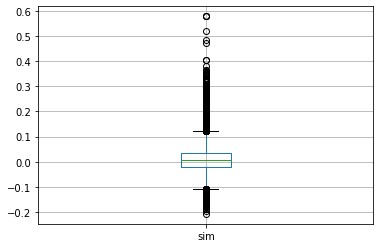

In [13]:
workpath = '/home/qjy20472/pythonProjects/pyetl'
df = pd.read_excel(os.path.join(workpath, 'data/PID统计_all.xlsx'), sheet_name='PID')
df = df.loc[~df['target_desc'].isna()]
df['seg_desc'] = df['target_desc'].apply(lambda x: ' '.join(jieba.cut(x)))

# w2v
df.loc[:, 'vec_desc'] = w2v(df)

# cos similarities
sim_df = get_cos_similarities(df)
sim_df

In [15]:
sim_df.describe()

,sim
count,55184.000000
mean,0.011611
std,0.054256
min,-0.206966
25%,-0.021338
50%,0.006808
75%,0.036595
max,0.578353


In [23]:
sim_df.loc[sim_df['sim'] > 0.3].to_csv(os.path.join(workpath, 'data/PID统计_all_相似字段.csv'), index=False, encoding='utf-8-sig')